# Semantic Segmentation

Dataset Description

For this Semantic Segmentation Project, you will be working on the **ICPR Retinal Blood Vessels Dataset**


The dataset consists of **268** train images and **112** test images in 2 classes (**veins** and **background**).

There is no separate validation dataset, you can use the given test dataset for validation.

The dataset is structured as follows:

```
icpr_prepared/
├── train_images/
│   ├── image_100.tif
│   ├── image_101.tif
│   └── ...
├── train_labels/
│   ├── image_100.tif
│   ├── image_101.tif
│   └── ...
├── test_images/
│   ├── image_121.tif
│   ├── image_122.tif
│   └── ...
└── test_labels/
    ├── image_121.tif
    ├── image_122.tif
    └── ...
```
---

Images and their corresponding binary masks are of `.tif` file format and are named with a unique `ImageId` as the filename.

In [1]:
import os
import cv2
import glob
import timm
import torch
import random
import zipfile
import requests
import datasets
import functools
import transformers
import torchmetrics
import albumentations as A


import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from monai import losses

from torchinfo import summary

from dataclasses import dataclass

from datasets import Features, List, Value


from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

import segmentation_models_pytorch as smp

from transformers import modeling_outputs

from transformers import (
    SegformerForSemanticSegmentation,
    SegformerImageProcessor,
    AutoModelForImageSegmentation,
    TrainingArguments,
    EvalPrediction,
    AutoModel,
    Trainer,
)

In [2]:
@dataclass(frozen=True)
class Config:
    WIDTH: int = 704
    HEIGHT: int = 576
    BATCH_SIZE: int = 4
    EPOCHS: float = 10.0
    LEARNING_RATE: float = 1e-4
    WEIGHT_DECAY: float = 1e-5
    NUM_WORKERS: int = 0
    THRESHOLD: float = 0.6
    REPORT: str = "none"
    CACHE_DIR: str = "./.cache"
    ROOT_DIR: str = "../"
    DATASET_DIR: str = "./"

## 1. Data Exploration

In [3]:
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        with zipfile.ZipFile(save_path) as z:
            z.extractall(
                os.path.join(
                    os.path.split(save_path)[0], "retinal_blood_vessel_icpr_seg"
                )
            )
            print("Done")
    except:
        print("Invalid file")

In [4]:
import dotenv

dotenv.load_dotenv()

dataset_name = "retinal_blood_vessel_icpr_seg"
dataset_zip_path = os.path.join(Config.DATASET_DIR, f"{dataset_name}.zip")
dataset_path = os.path.join(Config.DATASET_DIR, dataset_name)

# Download if dataset does not exists.
if not os.path.exists(dataset_path):
    download_and_unzip(os.environ["SEGMENTATION"], dataset_zip_path)

In [5]:
def visualize(dataset: datasets.Dataset, r: int = 5):
    plt.subplots(r, 2, figsize=(10, 21))

    for i, element in enumerate(dataset):
        img = element["image"]  # type: ignore
        msk = element["mask"]  # type: ignore

        if img is None or msk is None:
            break

        plt.subplot(r, 2, 2 * i + 1)
        plt.title(f"Image: {img.size[-2]}x{img.size[-1]}")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(r, 2, 2 * i + 2)
        plt.title(f"Mask: {msk.size[-2]}x{msk.size[-1]}")
        plt.imshow(msk, cmap="gray")
        plt.axis("off")

        if i == r - 1:
            break

    plt.tight_layout()

In [6]:
def create_dataset(image_path: str, mask_path: str):
    images_path = sorted(glob.glob(os.path.join(image_path, "*.tif")))
    masks_path = sorted(glob.glob(os.path.join(mask_path, "*.tif")))

    images = []
    labels = []

    for image, label in zip(images_path, masks_path):
        images.append(image)
        labels.append(label)

    return datasets.Dataset.from_dict({"image": images, "mask": labels})

In [7]:
train_dataset = create_dataset(
    os.path.join(Config.DATASET_DIR, "./retinal_blood_vessel_icpr_seg/train_images"),
    os.path.join(Config.DATASET_DIR, "./retinal_blood_vessel_icpr_seg/train_labels"),
)

test_dataset = create_dataset(
    os.path.join(Config.DATASET_DIR, "./retinal_blood_vessel_icpr_seg/test_images"),
    os.path.join(Config.DATASET_DIR, "./retinal_blood_vessel_icpr_seg/test_labels"),
)

train_dataset = train_dataset.cast_column(
    "image", datasets.Image(mode="RGB")
).cast_column("mask", datasets.Image(mode="1"))

test_dataset = test_dataset.cast_column(
    "image", datasets.Image(mode="RGB")
).cast_column("mask", datasets.Image(mode="1"))

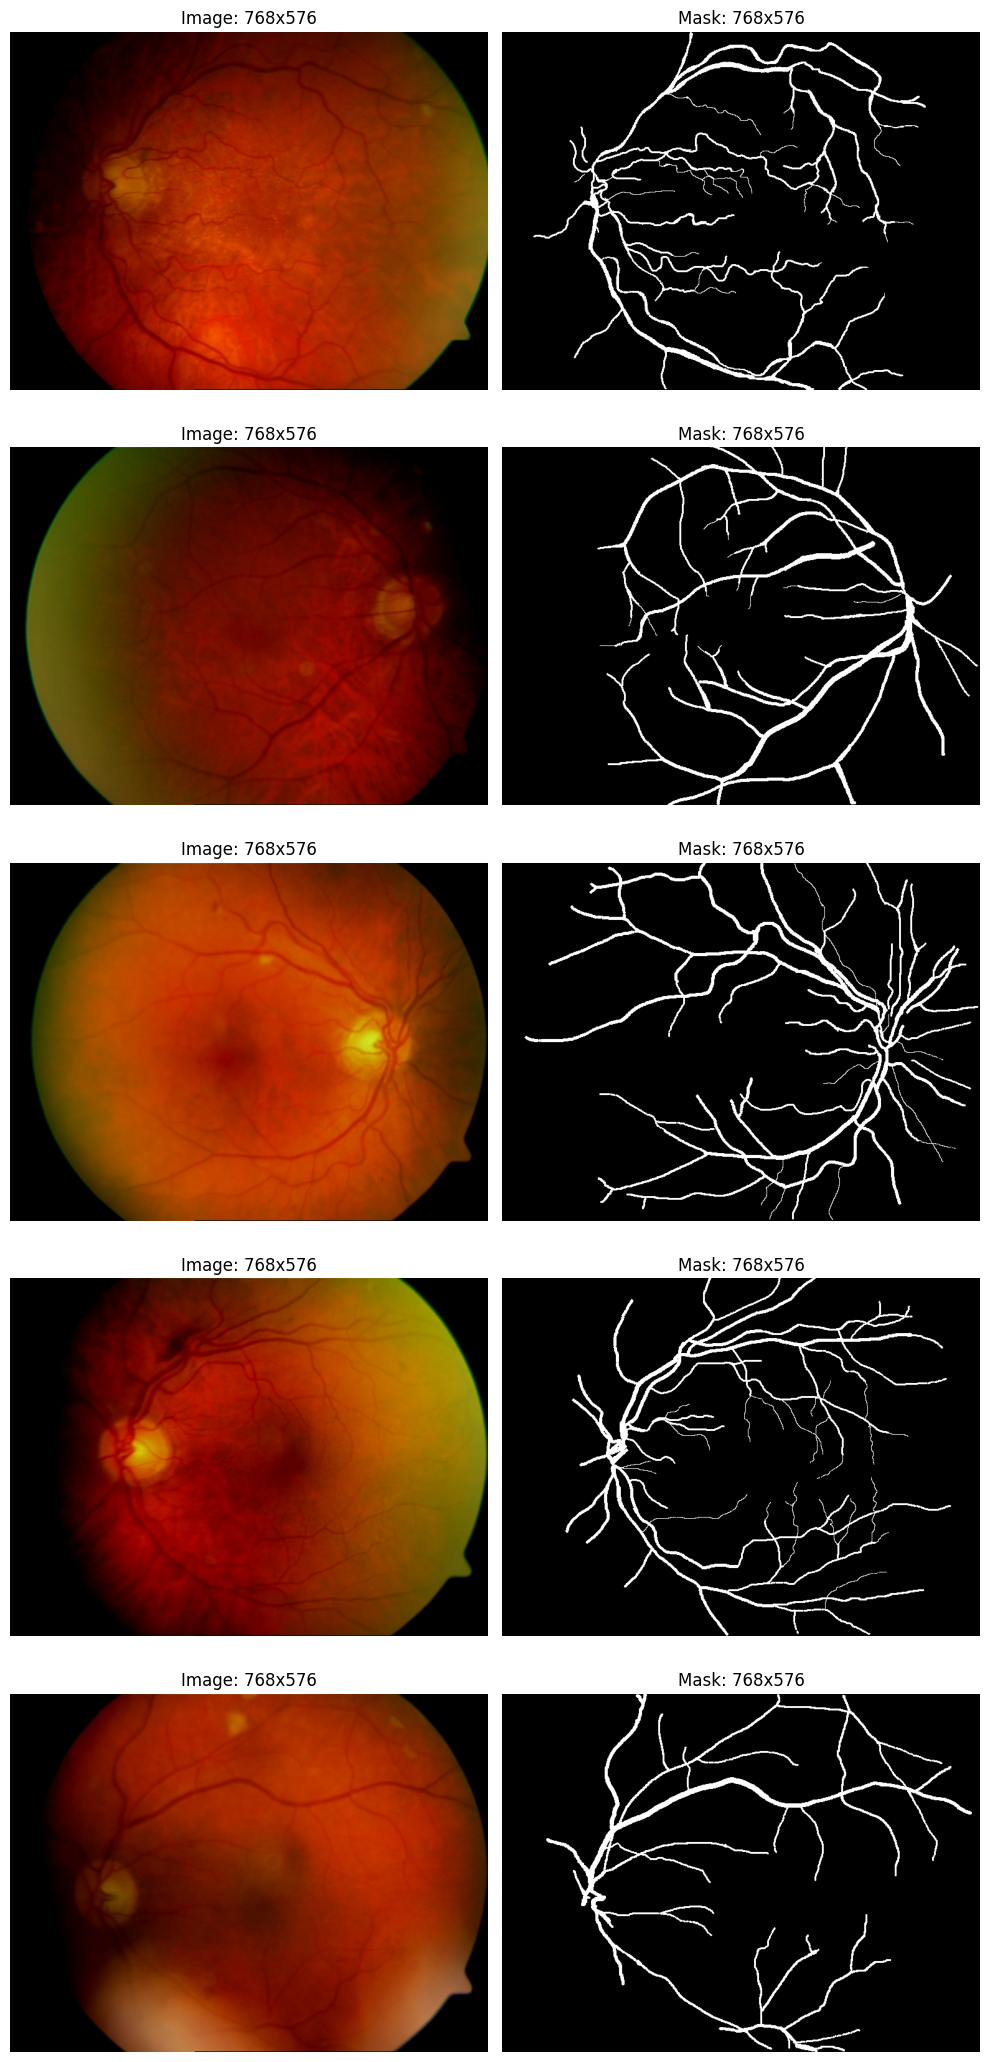

In [8]:
visualize(train_dataset)

## 2. Evaluation Metrics

In [9]:
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
iou_metric_binary = torchmetrics.JaccardIndex(
    task="binary",
    threshold=Config.THRESHOLD,
    average="macro",
    ignore_index=-1,
)


def evaluate_metrics(eval_pred: EvalPrediction) -> dict:
    logits, target = eval_pred

    logits = torch.from_numpy(logits)
    target = torch.from_numpy(target)

    if logits.ndim == 4:
        logits = logits.squeeze(1)

    probs = torch.sigmoid(logits)

    if probs.ndim == 3:
        probs = probs.unsqueeze(1)

    if target.ndim == 3:
        target = target.unsqueeze(1)

    # Compute IoU
    iou = iou_metric_binary(probs, target)

    # IMPORTANT: reset state
    iou_metric_binary.reset()

    return {"iou": iou.item()}


def collate_fn(batch):
    pv = torch.stack([x["pixel_values"] for x in batch])
    li = torch.stack([x["labels"] for x in batch])

    return {"pixel_values": pv.contiguous(), "labels": li.contiguous()}

## 3. Model

In [ ]:
class BloodVesselConfig(transformers.PretrainedConfig):
    model_type = "blood_vessel_net"


class BloodVesselNetForImageSegmentation(transformers.PreTrainedModel):

    config_class = BloodVesselConfig

    def __init__(self, config: BloodVesselConfig) -> None:
        super().__init__(config)
        self.model = smp.UnetPlusPlus(
            encoder_name="timm-efficientnet-b4", encoder_weights="imagenet", classes=1
        )

        self.dice_fn = losses.dice.DiceLoss(
            sigmoid=True,
            include_background=True,
            squared_pred=True,
            reduction="mean",
        )

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: torch.Tensor | None = None,
        **kwargs,
    ):
        logits = self.model(pixel_values)

        if logits.ndim == 3:
            logits = logits.unsqueeze(1)

        loss = None
        if labels is not None:

            if labels.ndim == 3:
                labels = labels.unsqueeze(1)

            loss = self.dice_fn(logits, labels)

        return modeling_outputs.SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
        )

In [12]:
model = BloodVesselNetForImageSegmentation(
    config=BloodVesselConfig(num_labels=1, num_non_trainable_layers=160)
)

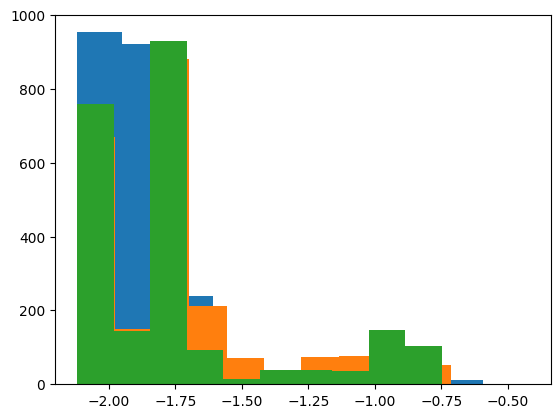

In [13]:
images = train_dataset[0]["image"]

transform = A.Normalize(normalization="standard")

images = transform(image=np.array(images))["image"]

for i in range(3):
    plt.hist(images[i].flatten())
plt.show()

In [14]:
train_transform = A.Compose(
    [
        A.Resize(Config.HEIGHT, Config.WIDTH),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(
            normalization="standard",
        ),
        A.ToTensorV2(),
    ],
    is_check_shapes=False,
)

test_transform = A.Compose(
    [
        A.Resize(Config.HEIGHT, Config.WIDTH),
        A.Normalize(
            normalization="standard",
        ),
        A.ToTensorV2(),
    ],
    is_check_shapes=False,
)


def preprocess(transform, images, segmentation_maps):
    images = np.array(images, dtype=np.float32)
    segmentation_maps = np.array(segmentation_maps, dtype=np.float32)
    
    augmented = transform(image=images, mask=segmentation_maps)

    return {
        "pixel_values": augmented["image"],
        "labels": augmented["mask"],
    }

## 4. Train & Inference

In [15]:
training_args = TrainingArguments(
    output_dir=os.path.join(Config.ROOT_DIR, "models", "segmentation"),
    num_train_epochs=Config.EPOCHS,
    learning_rate=Config.LEARNING_RATE,
    weight_decay=Config.WEIGHT_DECAY,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    dataloader_num_workers=Config.NUM_WORKERS,
    save_strategy="best",
    eval_strategy="steps",
    greater_is_better=True,
    metric_for_best_model="iou",
    save_total_limit=1,
    adam_epsilon=1e-10,
    load_best_model_at_end=True,
    batch_eval_metrics=False,
    logging_strategy="steps",
    logging_steps=(len(train_dataset) // Config.BATCH_SIZE) + 1,
    eval_accumulation_steps=1,
    report_to=Config.REPORT,
    lr_scheduler_type="reduce_lr_on_plateau",
    push_to_hub=False,
)

In [16]:
train_preprocess = functools.partial(
    preprocess,
    train_transform,
)
test_preprocess = functools.partial(
    preprocess,
    test_transform,
)

train_loader = (
    train_dataset.map(
        lambda r: train_preprocess(r["image"], r["mask"]),
        remove_columns=train_dataset.column_names,
    )
    .shuffle(seed=42)
    .with_format("torch")
)


test_loader = test_dataset.map(
    lambda r: test_preprocess(r["image"], r["mask"]),
    remove_columns=train_dataset.column_names,
).with_format("torch")

Map:   0%|          | 0/138 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_loader,
    eval_dataset=test_loader,
    compute_metrics=evaluate_metrics,
    data_collator=collate_fn,
)

trainer.train()

/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Iou
35,0.724000,0.711880,0.173036
70,0.690300,0.662537,0.218925
105,0.670400,0.627531,0.229177
140,0.656000,0.603016,0.233584
175,0.644400,0.596732,0.215650
210,0.632100,0.588759,0.235565
245,0.622400,0.603781,0.181618
280,0.617500,0.573435,0.252224
315,0.611600,0.576614,0.226259
350,0.601800,0.665687,0.126268


/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned 

TrainOutput(global_step=350, training_loss=0.647042372567313, metrics={'train_runtime': 440.6897, 'train_samples_per_second': 3.131, 'train_steps_per_second': 0.794, 'total_flos': 0.0, 'train_loss': 0.647042372567313, 'epoch': 10.0})

In [18]:
trainer.evaluate()

{'eval_loss': 0.6656871438026428,
 'eval_iou': 0.126268208026886,
 'eval_runtime': 5.6992,
 'eval_samples_per_second': 7.019,
 'eval_steps_per_second': 1.755,
 'epoch': 10.0}

In [19]:
def plot_hist(log_hist, labels, axis, title, colors, metrics):
    from matplotlib.ticker import MaxNLocator

    plt.rcParams["figure.figsize"] = (14, 10)
    fig = plt.figure()
    fig.set_facecolor("white")

    trends = [
        [[value["step"], value[m]] for value in log_hist if m in value] for m in metrics
    ]

    for trend, color, label in zip(trends, colors, labels):

        if not trend:
            continue

        trend = np.array(trend)

        plt.plot(
            trend[:, 0],
            trend[:, 1],
            color=color,
            label=label,
        )

    plt.ylabel(axis)
    plt.legend(loc="upper center")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title(title)
    plt.show()

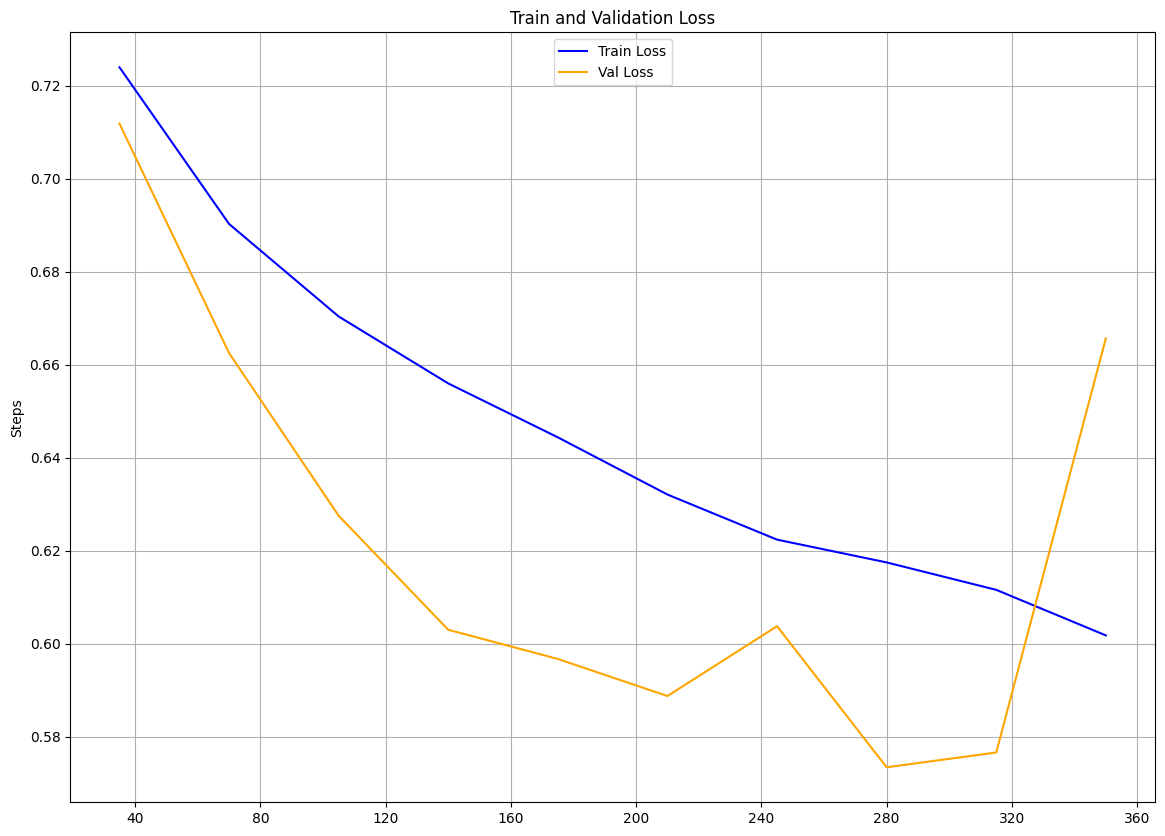

In [20]:
plot_hist(
    trainer.state.log_history,
    metrics=["loss", "eval_loss"],
    labels=["Train Loss", "Val Loss"],
    colors=["blue", "orange"],
    axis="Steps",
    title="Train and Validation Loss",
)

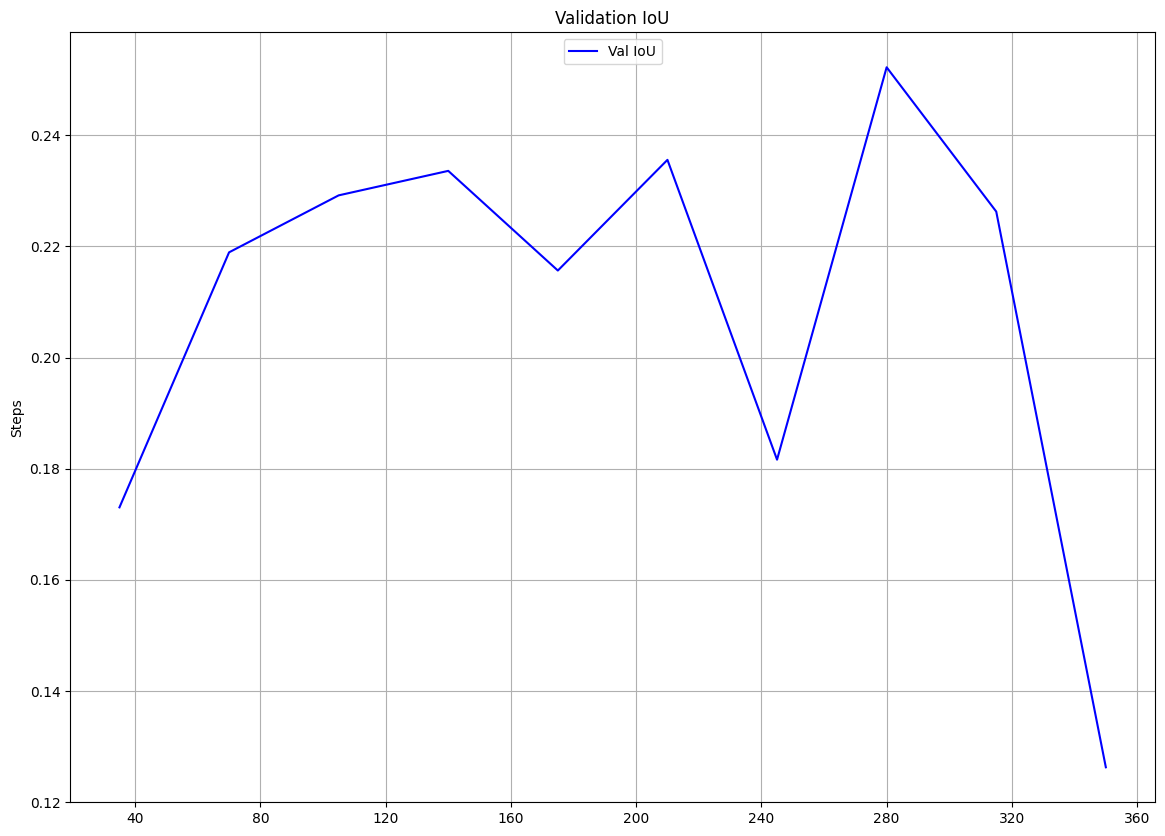

In [21]:
plot_hist(
    trainer.state.log_history,
    metrics=["eval_iou"],
    labels=["Val IoU"],
    colors=["blue"],
    axis="Steps",
    title="Validation IoU",
)

## 5. Inference

/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:2446: UserWarning: for conv_stem.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bi

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

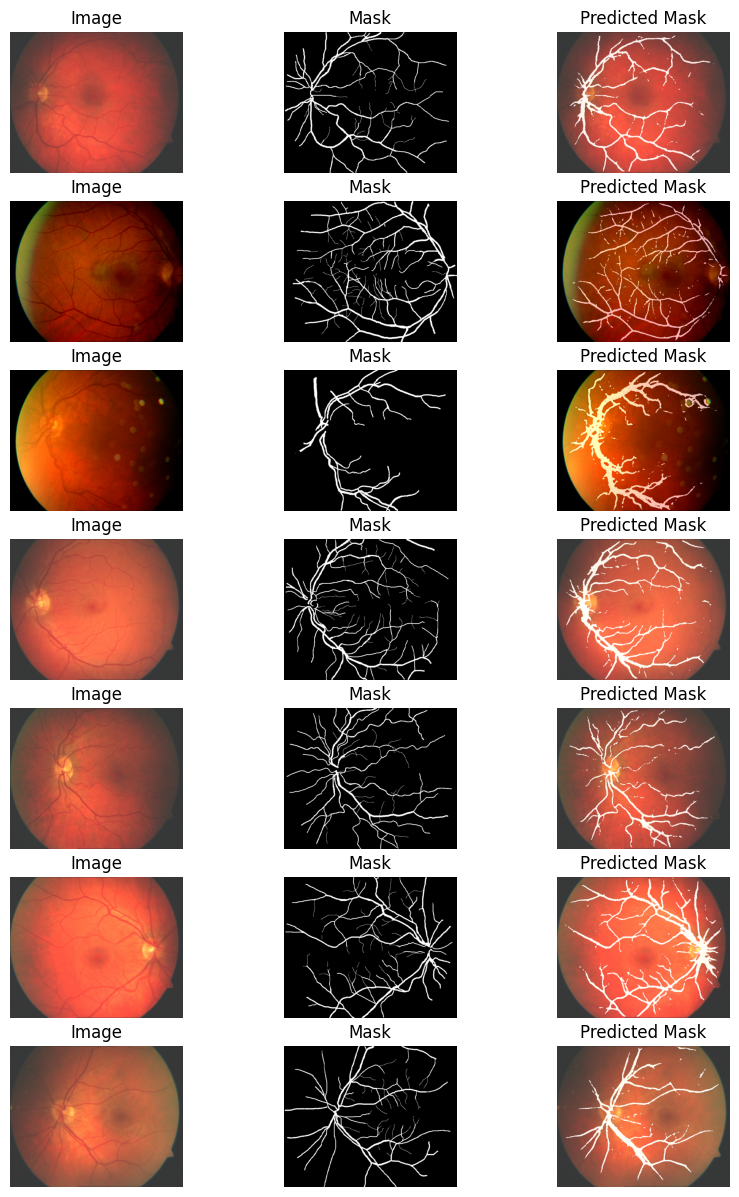

In [22]:
r = 7
c = 3

path = glob.glob(os.path.join(Config.ROOT_DIR, "models/segmentation", "*"))

model = BloodVesselNetForImageSegmentation.from_pretrained(path[-1]).to(device=get_default_device())
model.eval()


test_loader = test_dataset.map(
    lambda r: test_preprocess(r["image"], r["mask"]),
).with_format("torch")

plt.subplots(r, c, figsize=(10, 15))


for j, i in enumerate(range(0, r * c, 3)):
    k = random.randint(0, len(test_loader) - 1)
    dt = test_loader[k]["image"]
    gt = test_loader[k]["labels"]
    pv = test_loader[k]["pixel_values"].to(get_default_device())

    im = (dt.permute(1, 2, 0).cpu().numpy()).astype(np.uint8)
    resized = A.Resize(Config.HEIGHT, Config.WIDTH)(image=im)
    im = resized["image"]
    gt = (gt.cpu().numpy() * 255.0).astype(np.uint8)

    with torch.no_grad():
        outputs = model(pv.unsqueeze(0))
        probs = torch.sigmoid(outputs.logits)
        segmentation_maps = (probs > Config.THRESHOLD)
        segmentation_maps = segmentation_maps[0].permute(
            1, 2, 0
        ).squeeze().cpu().numpy().astype(np.uint8) * 255

    overlay = np.zeros_like(im, dtype=np.uint8)
    overlay[:, :, 0] = segmentation_maps
    overlay[:, :, 1] = segmentation_maps
    overlay[:, :, 2] = segmentation_maps

    weighted = cv2.addWeighted(im, 1.0, overlay, 0.7, 0.0)

    plt.subplot(r, c, i + 1)
    plt.imshow(im)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(r, c, i + 2)
    plt.imshow(gt, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(r, c, i + 3)
    plt.imshow(weighted)
    plt.title("Predicted Mask")
    plt.axis("off")

    if j == r - 1:
        break